In [1]:
# Exports QuantumCollocation, NamedTrajectories, and TrajectoryIndexingUtils
using Piccolo
using LinearAlgebra

# Plots
using CairoMakie

In [2]:
const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units

const n_qubits = 1
const n_levels = 2

t_f = 500 * ns
n_steps = 51
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
Δt = times[2] - times[1]

10.0

In [3]:
# Operators
Paulis = Dict(
    "I" => Matrix{ComplexF64}(I, 2, 2),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 -im; im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)
Rx(theta)  = kron(Paulis["I"],exp(-im * theta * Paulis["X"]/2))
Ry(theta)  = kron(Paulis["I"],exp(-im * theta * Paulis["Y"]/2))
Rz(theta)  =  kron(Paulis["I"],exp(-im * theta * Paulis["Z"]/2))

Rz (generic function with 1 method)

In [4]:
a = [0 1; 0 0]
ad = transpose(a)
a0  = kron(a,Paulis["I"])
ad0  = kron(ad,Paulis["I"])
a1  = kron(Paulis["I"],a)
ad1  = kron(Paulis["I"],ad)

4×4 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 1.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im  0.0+0.0im

In [5]:
H_drift = [ ]
H_drives = [
    ad0 * a0,
    ad1 * a1,
    a0+ad0,
    im * (a0-ad0),
    a1+ad1,
    im * (a1-ad1),
    ad0 * a1 + a0 * ad1
]
system = QuantumSystem(H_drives)

QuantumSystem{Float64}([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0; 1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 -0.0 0.0 0.0], [0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0], [0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 -0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0]], [[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0; -1.0 0.0 0.0 0.0; 0.0 -1.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.

In [6]:
target=Rx(pi/2)

4×4 Matrix{ComplexF64}:
 0.707107+0.0im            0.0-0.707107im  …       0.0+0.0im
      0.0-0.707107im  0.707107+0.0im               0.0+0.0im
      0.0+0.0im            0.0+0.0im               0.0-0.707107im
      0.0+0.0im            0.0+0.0im          0.707107+0.0im

In [7]:
PICO_max_iter = 1000

# Shape the cost function with weights on states and controls
Q = 100.
R = .5

# Add control bounds
a_bound = 2 * π * 500 * MHz
dda_bound = .05

problem = UnitarySmoothPulseProblem(
    system,
    target,
    n_steps,
    Δt;
    a_bound=a_bound,
    dda_bound=dda_bound,
    Q=Q,
    R=R,
    verbose=true,
    hessian_approximation=true,
    pade_order=10,
    free_time=false,
    timesteps_all_equal=true,
    subspace=[1, 2,3,4],
    max_iter=PICO_max_iter,
)

    building dynamics from integrators...
        constructing knot point dynamics functions...
        determining dynamics derivative structure...
            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(54) … MOI.VariableIndex(2598) MOI.VariableIndex(2651); MOI.VariableIndex(2) MOI.VariableIndex(55) … MOI.VariableIndex(2599) MOI.VariableIndex(2652); … ; MOI.VariableIndex(52) MOI.VariableIndex(105) … MOI.VariableIndex(2649) MOI.VariableIndex(2702); MOI.VariableIndex(53) MOI.VariableIndex(106) … MOI.VariableIndex(2650) MOI.VariableIndex(2703)], QuantumSystem{Float64}([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0; 1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 -0.0 0.0 0.0], [0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0], [0.0 0.0 0.0 0.0; -0.0 0.0 0.

In [8]:
solve!(problem)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    38406
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2657
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      700
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2300
Total number of inequality c

  78  1.5847182e+01 3.01e-01 1.95e+01  -4.0 2.85e-01    -  1.00e+00 2.50e-01h  3
  79  1.3981015e+01 2.40e+01 6.82e+01  -4.0 8.30e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.3862679e+01 3.29e+00 1.86e+01  -4.0 6.57e-01    -  1.00e+00 1.00e+00h  1
  81  1.3938232e+01 1.36e+00 1.87e+01  -4.0 2.50e-01    -  1.00e+00 1.00e+00h  1
  82  1.3220358e+01 1.10e+00 1.83e+01  -4.0 2.70e-01    -  1.00e+00 1.00e+00h  1
  83  1.2008971e+01 1.09e+01 1.88e+01  -4.0 1.31e+00    -  1.00e+00 5.00e-01f  2
  84  1.6954440e+01 6.18e+00 1.72e+01  -4.0 1.02e+00    -  1.00e+00 1.00e+00h  1
  85  1.1477523e+01 5.25e+00 1.87e+01  -4.1 1.04e+00    -  1.00e+00 1.00e+00f  1
  86  1.1469001e+01 4.92e+00 1.75e+01  -4.0 6.81e-01    -  1.00e+00 6.25e-02f  5
  87  1.2429264e+01 3.00e+00 6.30e+01  -4.0 6.96e-01    -  1.00e+00 1.00e+00h  1
  88  1.1939668e+01 1.46e+00 1.73e+01  -4.0 5.60e-01    -  1.00e+00 1.00e+00h  1
  89  1.1787098e+01 1.32e+00

 171  2.4729517e+00 1.18e+00 1.63e+01  -3.3 1.23e+00    -  1.00e+00 5.92e-01h  1
 172  2.2704380e+00 3.70e-01 1.70e+01  -3.3 4.34e-01    -  1.00e+00 1.00e+00f  1
 173  2.2112818e+00 5.65e-01 1.66e+01  -3.3 6.45e-01    -  2.47e-01 1.00e+00f  1
 174  2.3685662e+00 3.27e-01 1.67e+01  -3.6 2.15e-01    -  9.84e-01 1.00e+00H  1
 175  2.2876694e+00 5.94e-01 1.69e+01  -3.7 2.51e+00    -  1.32e-01 2.61e-01f  1
 176  2.2432942e+00 1.17e+00 1.67e+01  -3.7 1.07e+00    -  1.44e-02 5.19e-01F  1
 177  2.1675556e+00 9.53e-01 1.67e+01  -3.7 2.75e+00    -  1.00e+00 1.83e-01f  2
 178  2.1247279e+00 6.90e-01 1.69e+01  -1.5 1.71e+00    -  7.19e-01 2.70e-01f  2
 179  2.1572038e+00 1.42e-01 1.66e+01  -1.4 4.55e-01    -  9.89e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  2.1171859e+00 1.01e+00 1.69e+01  -1.6 3.57e-01    -  1.00e+00 1.00e+00f  1
 181  2.1111943e+00 9.92e-01 1.71e+01  -1.1 1.96e+00    -  1.00e+00 2.17e-02h  6
 182  2.0290561e+00 3.34e-01

 264  4.7773341e-01 2.51e-01 1.71e+01  -3.0 3.87e-01    -  1.00e+00 1.00e+00h  1
 265  5.1422750e-01 1.86e-01 1.69e+01  -2.7 4.08e-01    -  1.00e+00 1.00e+00h  1
 266  4.5634514e-01 6.38e-02 1.71e+01  -2.9 2.30e-01    -  1.00e+00 1.00e+00h  1
 267  4.6236172e-01 5.81e-02 1.67e+01  -3.1 2.94e-01    -  1.00e+00 5.00e-01h  2
 268  4.6002538e-01 4.46e-02 1.71e+01  -4.0 1.26e-01    -  1.00e+00 5.00e-01h  2
 269  4.5776042e-01 2.26e-02 1.68e+01  -4.0 1.71e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  4.5058186e-01 2.79e-02 1.68e+01  -4.0 1.13e-01    -  1.00e+00 1.00e+00h  1
 271  4.4834650e-01 3.85e-02 1.71e+01  -4.0 3.19e-01    -  1.00e+00 2.50e-01h  3
 272  4.4695879e-01 2.38e-02 1.71e+01  -4.0 8.35e-02    -  1.00e+00 5.00e-01h  2
 273  4.6862627e-01 4.53e-03 1.71e+01  -4.0 1.81e-01    -  1.00e+00 1.00e+00H  1
 274  4.6507060e-01 9.39e-03 1.70e+01  -4.0 1.91e-01    -  1.00e+00 2.50e-01h  3
 275  4.5304034e-01 1.15e-01

 357  2.9739971e-01 1.53e-03 1.77e+01  -4.0 7.70e-02    -  1.00e+00 5.00e-01h  2
 358  2.9895043e-01 1.68e-03 1.67e+01  -4.0 1.08e-01    -  1.00e+00 5.00e-01h  2
 359  2.9672431e-01 3.44e-03 1.78e+01  -4.1 1.96e-01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  2.9465949e-01 4.61e-03 1.72e+01  -4.0 7.32e-02    -  1.00e+00 1.00e+00h  1
 361  2.9425828e-01 5.48e-03 1.72e+01  -4.0 4.16e-01    -  1.00e+00 6.25e-02h  5
 362  2.9134600e-01 6.45e-03 1.73e+01  -4.0 5.25e-02    -  1.00e+00 1.00e+00h  1
 363  2.9068223e-01 6.68e-03 1.69e+01  -3.4 1.83e+00    -  1.00e+00 1.71e-02h  5
 364  2.8941400e-01 7.66e-03 1.73e+01  -2.9 1.40e+00    -  1.00e+00 3.35e-02h  5
 365  2.8835181e-01 7.86e-03 1.69e+01  -2.2 1.47e+00    -  9.98e-01 2.24e-02h  5
 366  2.8623322e-01 4.76e-02 1.73e+01  -2.6 4.14e-01    -  1.00e+00 5.00e-01h  2
 367  2.8480185e-01 4.56e-02 1.73e+01  -2.0 9.08e-01    -  1.00e+00 7.70e-02h  4
 368  3.0471121e-01 1.57e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  2.0578712e-01 1.50e-02 1.69e+01  -4.0 1.24e-01    -  1.00e+00 1.00e+00h  1
 451  2.0364352e-01 5.08e-03 1.68e+01  -4.0 7.85e-02    -  1.00e+00 1.00e+00h  1
 452  2.0351741e-01 3.44e-03 1.70e+01  -4.0 9.55e-02    -  1.00e+00 5.00e-01h  2
 453  2.0279741e-01 3.07e-03 1.69e+01  -4.0 1.76e-01    -  1.00e+00 2.50e-01h  3
 454  2.0300805e-01 2.95e-03 1.69e+01  -3.5 9.57e-01    -  1.00e+00 3.64e-02h  5
 455  2.0150711e-01 2.91e-03 1.71e+01  -3.6 2.38e-01    -  1.00e+00 2.50e-01h  3
 456  2.0039510e-01 1.61e-02 1.66e+01  -3.7 2.26e-01    -  1.00e+00 1.00e+00H  1
 457  1.9844437e-01 2.80e-03 1.71e+01  -4.0 6.48e-02    -  1.00e+00 1.00e+00h  1
 458  1.9671838e-01 3.00e-03 1.70e+01  -4.0 5.46e-02    -  1.00e+00 1.00e+00h  1
 459  1.9490286e-01 1.96e-02 1.70e+01  -4.0 1.55e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  2.3002383e-01 5.75e-02

 542  1.4918695e-01 3.23e-04 1.71e+01  -4.0 3.75e-02    -  1.00e+00 5.00e-01h  2
 543  1.5015028e-01 3.23e-04 1.69e+01  -3.1 3.49e+00    -  1.00e+00 1.82e-02h  4
 544  1.4960106e-01 6.43e-04 1.71e+01  -3.2 5.00e-02    -  1.00e+00 1.00e+00h  1
 545  1.4937596e-01 5.45e-04 1.70e+01  -3.2 2.03e-01    -  1.00e+00 1.25e-01h  4
 546  1.4927417e-01 1.13e-03 1.70e+01  -3.2 8.52e-02    -  1.00e+00 5.00e-01h  2
 547  1.4912616e-01 1.94e-02 1.70e+01  -3.2 2.38e+00    -  1.00e+00 6.25e-02h  5
 548  1.4772615e-01 1.07e-01 1.70e+01  -4.0 9.82e-01    -  1.00e+00 2.50e-01h  3
 549  1.5014730e-01 8.02e-02 1.70e+01  -4.0 2.70e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  2.4047505e-01 6.58e-02 1.69e+01  -4.1 8.88e-01    -  5.61e-01 6.76e-01H  1
 551  1.7886890e-01 2.62e-02 1.70e+01  -4.1 3.32e-01    -  4.01e-03 1.00e+00f  1
 552  2.0318446e-01 3.22e-02 1.70e+01  -4.1 6.46e-01    -  1.00e+00 1.00e+00h  1
 553  2.1411740e-01 3.13e-02

 635  1.2364018e-01 5.84e-03 1.69e+01  -4.1 1.93e-01    -  1.00e+00 5.00e-01h  2
 636  1.2218103e-01 6.22e-03 1.70e+01  -4.1 1.02e+00    -  7.12e-01 3.32e-02h  5
 637  1.1749478e-01 2.04e-02 1.69e+01  -4.1 5.99e-01    -  4.49e-01 2.50e-01h  3
 638  1.1772616e-01 1.70e-02 1.69e+01  -4.1 2.72e-01    -  1.00e+00 2.50e-01h  3
 639  1.1535611e-01 6.28e-03 1.69e+01  -4.1 1.02e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  1.3048409e-01 4.85e-03 1.69e+01  -3.7 8.73e-01    -  1.00e+00 3.06e-01h  2
 641  1.2526336e-01 7.85e-03 1.69e+01  -3.8 3.62e-01    -  7.15e-01 5.00e-01h  2
 642  1.1622169e-01 9.47e-03 1.69e+01  -3.8 1.92e+00    -  1.85e-01 8.23e-02f  3
 643  1.1594652e-01 9.35e-03 1.69e+01  -3.8 2.54e+00    -  2.18e-01 1.17e-02h  5
 644  1.2045627e-01 7.85e-03 1.69e+01  -3.8 1.21e-01    -  1.00e+00 1.00e+00h  1
 645  1.2372288e-01 4.43e-03 1.69e+01  -3.8 3.11e-01    -  1.00e+00 5.00e-01h  2
 646  1.2363756e-01 4.84e-03

 728  1.0046875e-01 5.67e-03 1.70e+01  -4.0 2.26e-01    -  1.00e+00 2.50e-01h  3
 729  9.9895576e-02 2.48e-03 1.70e+01  -4.0 5.53e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  1.0059567e-01 2.38e-03 1.70e+01  -4.0 4.70e-01    -  1.00e+00 6.25e-02h  5
 731  9.9344591e-02 6.25e-03 1.71e+01  -4.0 8.29e-02    -  1.00e+00 1.00e+00h  1
 732  9.9247050e-02 6.17e-03 1.70e+01  -4.0 8.23e-01    -  1.00e+00 1.56e-02h  7
 733  9.9198781e-02 6.27e-03 1.71e+01  -4.0 9.35e-02    -  1.00e+00 1.00e+00h  1
 734  9.9016507e-02 5.82e-03 1.71e+01  -4.0 1.48e-01    -  1.00e+00 2.50e-01h  3
 735  9.9008475e-02 5.94e-03 1.71e+01  -3.6 2.53e+00    -  1.00e+00 5.61e-03h  7
 736  9.8893417e-02 1.00e-02 1.71e+01  -3.7 1.20e-01    -  1.00e+00 1.00e+00h  1
 737  1.0038719e-01 4.10e-03 1.70e+01  -4.0 6.46e-02    -  1.00e+00 1.00e+00h  1
 738  9.8744433e-02 2.24e-02 1.70e+01  -4.1 1.74e-01    -  1.00e+00 1.00e+00h  1
 739  9.8214038e-02 2.13e-02

 821  2.7947846e-01 3.36e-02 1.71e+01  -3.2 5.41e-01    -  1.00e+00 9.78e-01h  1
 822  9.0846196e-02 1.38e-02 1.70e+01  -3.3 4.68e-01    -  5.74e-02 1.00e+00f  1
 823  9.0482870e-02 1.38e-02 1.71e+01  -3.3 2.90e+01    -  1.93e-02 3.56e-05f 10
 824  9.8935667e-02 8.06e-03 2.17e+01  -3.3 1.86e-01    -  1.00e+00 5.00e-01h  2
 825  2.5401074e-01 1.67e-02 1.76e+01  -3.3 3.27e-01    -  9.44e-01 1.00e+00H  1
 826  2.0418440e-01 1.44e-02 1.75e+01  -3.3 5.75e-01    -  1.00e+00 1.67e-01f  3
 827  1.4077816e-01 1.12e-02 1.72e+01  -3.3 4.69e-01    -  3.17e-01 2.50e-01f  3
 828  8.5846216e-02 4.73e-03 1.69e+01  -3.3 2.29e-01    -  1.00e+00 1.00e+00f  1
 829  8.5031541e-02 1.43e-03 1.65e+01  -4.0 3.83e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  8.5193361e-02 1.43e-03 1.75e+01  -2.9 6.00e+00    -  1.00e+00 1.61e-04h 10
 831  8.5478854e-02 1.78e-03 1.92e+01  -3.0 4.19e-02    -  1.00e+00 1.00e+00h  1
 832  8.5179303e-02 8.14e-04

 914  7.9640420e-02 4.64e-02 1.70e+01  -3.5 3.12e-01    -  7.31e-01 1.00e+00h  1
 915  7.6042138e-02 4.98e-02 1.70e+01  -3.5 3.45e-01    -  1.00e+00 5.00e-01h  2
 916  7.3594592e-02 2.06e-02 1.70e+01  -4.0 1.64e-01    -  1.00e+00 1.00e+00h  1
 917  7.2346785e-02 2.37e-02 1.70e+01  -3.0 1.27e+01    -  1.00e+00 4.99e-03h  5
 918  7.3270538e-02 2.36e-02 1.70e+01  -2.7 1.27e+00    -  1.00e+00 1.66e-02h  6
 919  7.2536742e-02 8.60e-03 1.70e+01  -2.8 8.59e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  7.2214104e-02 6.69e-03 1.70e+01  -4.0 7.46e-02    -  1.00e+00 1.00e+00h  1
 921  7.2132051e-02 6.61e-03 1.70e+01  -3.5 8.76e-01    -  1.00e+00 1.80e-02h  6
 922  7.4250296e-02 5.54e-03 1.70e+01  -4.0 1.10e-01    -  1.00e+00 5.00e-01h  2
 923  7.3979551e-02 6.21e-03 1.70e+01  -3.7 9.82e-01    -  1.00e+00 3.12e-02h  6
 924  7.2227417e-02 2.31e-02 1.70e+01  -3.9 5.20e-01    -  1.00e+00 2.50e-01h  3
 925  7.1965566e-02 2.30e-02

In [15]:
result = copy(problem.trajectory)
rollout_states = unitary_rollout(result, system; integrator=exp)
abs(tr(target'iso_vec_to_operator(rollout_states[:,51]))/4)

0.9963976511528206

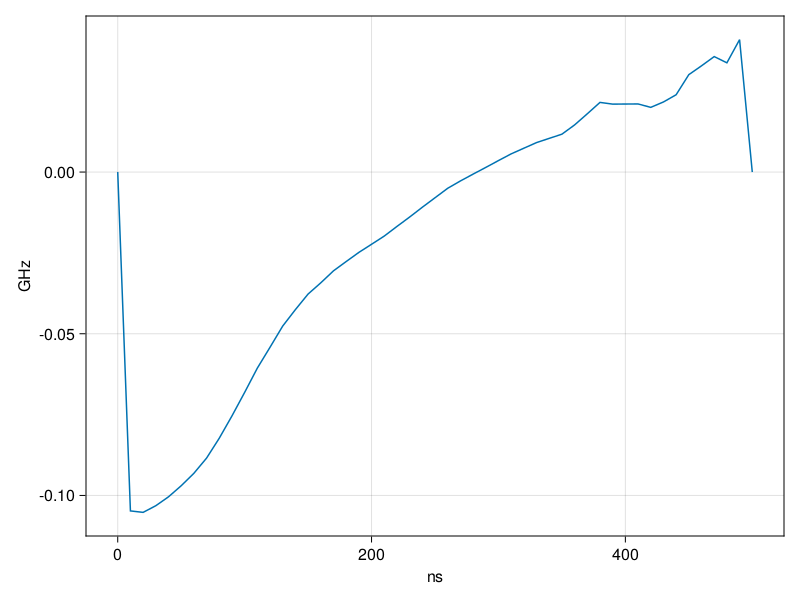

In [10]:
ts = accumulate(+, timesteps(result)) .- timesteps(result)[1]
as = result[:a]

f = Figure()
ax = Axis(f[1, 1], xlabel="ns", ylabel="GHz")

lines!(ax, ts, as[1, :], label="X")

f

In [11]:
target2 = Rx(1.2 * pi/2)
problem2 = UnitarySmoothPulseProblem(
    system,
    target2,
    n_steps,
    Δt;
    a_bound=a_bound,
    dda_bound=dda_bound,
    Q=Q,
    R=R,
    verbose=true,
    hessian_approximation=true,
    pade_order=10,
    free_time=false,
    timesteps_all_equal=true,
    subspace=[1, 2,3,4],
    max_iter=PICO_max_iter,
    init_trajectory = result
)

    building dynamics from integrators...
        constructing knot point dynamics functions...
        determining dynamics derivative structure...
            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda


QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(54) … MOI.VariableIndex(2598) MOI.VariableIndex(2651); MOI.VariableIndex(2) MOI.VariableIndex(55) … MOI.VariableIndex(2599) MOI.VariableIndex(2652); … ; MOI.VariableIndex(52) MOI.VariableIndex(105) … MOI.VariableIndex(2649) MOI.VariableIndex(2702); MOI.VariableIndex(53) MOI.VariableIndex(106) … MOI.VariableIndex(2650) MOI.VariableIndex(2703)], QuantumSystem{Float64}([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0; 1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -0.0 0.0 0.0 0.0; 0.0 -0.0 0.0 0.0], [0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0], [0.0 0.0 0.0 0.0; -0.0 0.0 0.

In [12]:
solve!(problem2)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:    38406
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2657
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      700
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2300
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.4257964e-02 2.89e-03 1.38e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

  82  7.0269360e-02 9.58e-03 1.70e+01  -3.5 1.93e+00    -  2.91e-01 3.14e-02h  4
  83  6.8058129e-02 6.66e-03 1.69e+01  -3.5 8.10e-02    -  1.00e+00 1.00e+00h  1
  84  6.7481655e-02 6.34e-03 1.69e+01  -3.5 5.31e-01    -  8.51e-01 1.25e-01h  4
  85  6.6224207e-02 4.74e-03 1.70e+01  -4.0 6.84e-02    -  1.00e+00 1.00e+00h  1
  86  6.6174350e-02 4.65e-03 1.69e+01  -4.0 3.57e-01    -  1.00e+00 3.12e-02h  6
  87  6.7693193e-02 4.25e-03 1.70e+01  -4.0 1.32e-01    -  1.00e+00 5.00e-01h  2
  88  6.7068668e-02 4.64e-03 1.70e+01  -3.6 7.69e-01    -  1.00e+00 4.55e-02h  5
  89  6.6977221e-02 5.43e-03 1.70e+01  -3.7 4.17e-01    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  6.7002112e-02 5.13e-03 1.70e+01  -3.7 2.54e-01    -  1.00e+00 6.25e-02h  5
  91  7.2804056e-02 3.83e-03 1.69e+01  -3.7 1.35e-01    -  1.00e+00 1.00e+00h  1
  92  6.6027409e-02 4.96e-03 1.71e+01  -3.7 9.80e-02    -  1.00e+00 1.00e+00h  1
  93  7.7103122e-02 1.08e-03

 175  5.7374069e-02 7.77e-03 1.71e+01  -3.5 1.25e+00    -  1.00e+00 1.24e-02h  6
 176  5.8476627e-02 7.58e-03 1.70e+01  -4.0 2.30e-01    -  1.00e+00 1.25e-01h  4
 177  5.6799798e-02 1.60e-02 1.70e+01  -4.0 1.17e-01    -  1.00e+00 1.00e+00h  1
 178  9.6668873e-02 8.58e-03 1.71e+01  -4.0 2.64e-01    -  1.00e+00 1.00e+00h  1
 179  5.6758697e-02 5.81e-03 1.70e+01  -4.1 2.13e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  5.6813773e-02 4.47e-03 1.70e+01  -4.0 1.12e-01    -  1.00e+00 2.50e-01h  3
 181  5.9962612e-02 3.52e-03 1.69e+01  -4.0 1.47e-01    -  1.00e+00 5.00e-01h  2
 182  5.9296113e-02 7.39e-03 1.70e+01  -4.0 7.79e-02    -  1.00e+00 1.00e+00h  1
 183  5.8698997e-02 7.35e-03 1.70e+01  -4.1 2.23e+00    -  1.96e-01 3.06e-02h  4
 184  5.7953916e-02 7.02e-03 1.70e+01  -4.1 9.98e-01    -  5.30e-01 3.01e-02h  5
 185  5.6771930e-02 4.28e-03 1.70e+01  -4.1 6.11e-02    -  1.00e+00 1.00e+00h  1
 186  5.6224044e-02 4.31e-03

 268  5.4365015e-02 1.81e-03 1.70e+01  -4.0 1.30e-01    -  1.00e+00 2.50e-01h  3
 269  5.4322656e-02 1.82e-03 1.70e+01  -4.1 1.94e+00    -  2.43e-01 4.00e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  5.4131095e-02 6.00e-03 1.70e+01  -4.1 9.56e-02    -  1.00e+00 1.00e+00h  1
 271  5.4085518e-02 5.93e-03 1.70e+01  -4.1 8.00e-01    -  1.00e+00 1.56e-02h  7
 272  5.4222627e-02 5.71e-03 1.70e+01  -4.1 4.13e-01    -  1.00e+00 3.12e-02h  6
 273  5.4064409e-02 4.49e-03 1.70e+01  -4.1 1.05e-01    -  1.00e+00 2.50e-01h  3
 274  5.4005934e-02 5.42e-03 1.70e+01  -4.1 1.36e+01    -  1.16e-01 3.83e-03h  6
 275  5.3781783e-02 7.60e-03 1.70e+01  -4.1 5.64e-01    -  1.00e+00 1.25e-01h  4
 276  5.3703393e-02 9.53e-03 1.70e+01  -3.5 1.33e+00    -  1.00e+00 3.16e-02h  5
 277  5.3580356e-02 9.43e-03 1.70e+01  -3.8 9.79e-01    -  1.00e+00 3.12e-02h  6
 278  5.3723724e-02 9.36e-03 1.70e+01  -4.0 4.52e-01    -  1.00e+00 3.12e-02h  6
 279  5.4488926e-02 6.60e-03

 361  4.7305011e-02 1.03e-01 1.69e+01  -1.9 1.18e+01    -  1.00e+00 1.88e-02h  6
 362  4.7207978e-02 1.55e-01 1.69e+01  -2.2 4.97e+00    -  1.00e+00 6.25e-02h  5
 363  2.9114257e+01 2.81e-01 2.96e+01  -2.6 5.82e+00    -  1.00e+00 1.25e-01h  4
 364  1.5608531e+01 1.11e-01 9.53e+01  -2.7 4.05e-01    -  1.00e+00 1.00e+00f  1
 365  9.1898844e+00 2.21e-01 3.45e+01  -2.7 9.45e-01    -  1.00e+00 5.00e-01f  2
 366  6.3987225e+00 6.25e-02 1.98e+01  -2.7 3.57e-01    -  1.00e+00 1.00e+00f  1
 367  1.4700860e+00 2.10e-02 1.82e+01  -2.7 1.39e-01    -  1.00e+00 1.00e+00f  1
 368  3.3958687e-01 2.33e-02 2.24e+01  -2.7 5.18e+00    -  1.00e+00 1.56e-02f  7
 369  5.7299053e-01 5.97e-03 1.28e+01  -2.7 9.08e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  2.9104185e-01 1.22e-02 2.33e+01  -2.7 2.37e-01    -  1.00e+00 5.00e-01f  2
 371  3.6956535e-01 4.86e-03 1.21e+01  -2.7 8.85e-02    -  1.00e+00 1.00e+00h  1
 372  3.1967157e-01 1.35e-03

 454  5.9040427e-02 1.15e-04 1.64e+01  -4.1 1.25e-02    -  1.00e+00 1.00e+00h  1
 455  5.6241494e-02 2.11e-03 2.08e+01  -4.0 5.13e-02    -  1.00e+00 1.00e+00h  1
 456  5.1776570e-02 5.37e-04 1.45e+01  -4.1 2.58e-02    -  1.00e+00 1.00e+00h  1
 457  6.1654785e-02 3.58e-04 1.56e+01  -4.0 2.17e-02    -  1.00e+00 1.00e+00h  1
 458  5.5590775e-02 5.89e-03 3.14e+01  -4.1 1.71e-01    -  1.00e+00 5.00e-01h  2
 459  6.0460920e-02 1.49e-03 1.19e+01  -4.1 4.31e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  5.8970106e-02 9.41e-04 1.70e+01  -4.1 2.98e-02    -  1.00e+00 1.00e+00h  1
 461  5.7746982e-02 1.49e-03 1.66e+01  -4.1 4.43e-01    -  1.00e+00 6.25e-02h  5
 462  4.7400237e-02 5.10e-04 1.49e+01  -4.1 2.37e-02    -  1.00e+00 1.00e+00h  1
 463  5.0760211e-02 3.79e-04 1.72e+01  -4.0 2.43e-02    -  1.00e+00 5.00e-01h  2
 464  4.9236056e-02 7.45e-04 2.37e+01  -4.0 5.40e-02    -  1.00e+00 5.00e-01h  2
 465  4.9038131e-02 5.52e-04

 547  5.0962399e-02 1.21e-02 1.69e+01  -4.1 6.25e-01    -  5.41e-01 2.50e-01h  3
 548  4.5286379e-02 1.08e-02 1.68e+01  -4.1 4.51e-01    -  1.00e+00 2.50e-01h  3
 549  4.4088568e-02 1.18e-02 1.68e+01  -4.1 5.92e-01    -  6.03e-01 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  4.1480908e-02 4.52e-03 1.68e+01  -4.1 8.65e-02    -  1.00e+00 1.00e+00h  1
 551  4.1275474e-02 5.83e-03 1.68e+01  -3.5 2.75e+00    -  1.00e+00 1.56e-02h  5
 552  4.2595778e-02 5.84e-03 1.68e+01  -3.2 6.71e-01    -  1.00e+00 4.60e-02h  5
 553  4.0679156e-02 2.50e-03 1.68e+01  -3.3 6.52e-02    -  1.00e+00 1.00e+00h  1
 554  4.0278500e-02 3.66e-03 1.68e+01  -3.8 3.19e-01    -  1.00e+00 1.25e-01h  4
 555  4.0328500e-02 3.65e-03 1.68e+01  -3.3 1.56e+00    -  1.00e+00 2.59e-03h  8
 556  4.0176745e-02 3.70e-03 1.68e+01  -4.0 5.24e-02    -  1.00e+00 1.00e+00h  1
 557  4.0105692e-02 3.65e-03 1.68e+01  -3.7 6.60e-01    -  1.00e+00 2.84e-02h  6
 558  4.1226455e-02 3.15e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  3.9680634e-02 9.03e-06 1.16e+01  -4.0 3.36e-03    -  1.00e+00 1.00e+00h  1
 641  3.9594035e-02 6.85e-06 2.28e+01  -4.0 5.45e-03    -  1.00e+00 5.00e-01h  2
 642  3.9557701e-02 5.33e-05 1.45e+01  -4.0 9.15e-03    -  1.00e+00 1.00e+00h  1
 643  3.9551804e-02 3.01e-05 1.72e+01  -4.1 6.72e-03    -  1.00e+00 1.00e+00H  1
 644  3.9521945e-02 2.98e-05 1.70e+01  -4.1 4.29e-02    -  1.00e+00 3.12e-02h  6
 645  4.8615628e-01 3.53e-05 2.43e+01  -4.0 6.59e-02    -  1.00e+00 1.00e+00H  1
 646  4.3363050e-02 3.56e-04 3.35e+01  -4.1 6.77e-02    -  1.00e+00 1.00e+00F  1
 647  4.0235601e-02 3.71e-07 3.34e+01  -4.1 5.21e-04    -  1.00e+00 1.00e+00h  1
 648  4.0138734e-02 6.86e-07 3.12e-01  -4.0 7.15e-04    -  1.00e+00 1.00e+00h  1
 649  4.0100183e-02 9.54e-05 2.72e+01  -4.0 7.53e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650  4.0182757e-02 1.83e-05

 732  4.1506737e-02 5.40e-03 1.66e+01  -3.8 6.80e-02    -  1.00e+00 1.00e+00h  1
 733  4.0761357e-02 5.40e-03 1.69e+01  -3.8 9.46e+01    -  2.38e-02 6.24e-06f 13
 734  3.9012884e-02 2.88e-03 2.39e+01  -3.8 6.21e-02    -  1.00e+00 1.00e+00h  1
 735  3.9779103e-02 1.31e-03 1.69e+01  -4.0 4.39e-02    -  1.00e+00 1.00e+00h  1
 736  4.0640062e-02 1.12e-03 1.68e+01  -4.1 6.93e-02    -  1.00e+00 2.50e-01h  3
 737  3.9238526e-02 9.41e-04 1.61e+01  -4.1 4.56e-02    -  1.00e+00 2.50e-01h  3
 738  3.9658349e-02 7.67e-04 1.65e+01  -4.1 2.93e-02    -  1.00e+00 1.00e+00h  1
 739  3.9169502e-02 7.51e-04 1.67e+01  -4.1 2.48e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740  3.9082114e-02 7.74e-04 1.64e+01  -4.0 6.53e-02    -  1.00e+00 2.50e-01h  3
 741  3.8843778e-02 5.33e-04 1.66e+01  -4.0 3.42e-02    -  1.00e+00 5.00e-01h  2
 742  3.8824270e-02 5.29e-04 1.66e+01  -4.0 1.77e-01    -  1.00e+00 6.25e-02h  5
 743  3.8740552e-02 4.92e-04

 825  3.7002467e-02 1.39e-02 1.65e+01  -4.0 1.44e-01    -  1.00e+00 1.00e+00h  1
 826  3.7382805e-02 1.05e-02 1.65e+01  -4.0 3.11e-01    -  1.00e+00 2.50e-01h  3
 827  3.7262903e-02 1.04e-02 1.65e+01  -3.4 1.81e+00    -  1.00e+00 8.67e-03h  6
 828  3.7256775e-02 1.04e-02 1.64e+01  -2.1 3.07e+01    -  1.00e+00 1.58e-06h 16
 829  3.7773049e-02 9.58e-03 1.75e+01  -2.2 3.98e-01    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  4.0353840e-02 5.88e-03 1.65e+01  -2.7 1.02e-01    -  1.00e+00 1.00e+00h  1
 831  3.8086878e-02 6.62e-03 1.65e+01  -2.8 1.43e-01    -  1.00e+00 5.00e-01h  2
 832  3.7795179e-02 6.11e-03 1.65e+01  -2.8 4.31e-01    -  1.00e+00 1.25e-01h  4
 833  3.7328852e-02 5.71e-03 1.65e+01  -3.0 2.65e-01    -  1.00e+00 1.25e-01h  4
 834  4.0929849e-02 2.70e-03 1.65e+01  -3.5 1.16e-01    -  1.00e+00 1.00e+00h  1
 835  4.0830840e-02 2.70e-03 1.64e+01  -3.6 3.30e+00    -  7.75e-01 2.38e-04h 13
 836  4.0689426e-02 4.35e-03

 918  3.6403816e-02 1.20e-04 4.08e+03  -4.0 1.08e-02    -  1.00e+00 1.00e+00h  1
 919  3.6197147e-02 4.50e-05 3.29e+03  -4.0 7.68e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  3.6607600e-02 3.18e-05 5.46e+03  -4.0 5.85e-03    -  1.00e+00 5.00e-01h  2
 921  3.7382623e-02 6.32e-06 7.84e+03  -4.0 5.02e-03    -  1.00e+00 1.00e+00H  1
 922  3.7538951e-02 2.37e-07 1.15e+03  -4.0 6.26e-04    -  1.00e+00 1.00e+00h  1
 923  3.7420529e-02 1.63e-07 1.44e+00  -4.0 5.31e-04    -  1.00e+00 1.00e+00h  1
 924  3.7695002e-02 7.92e-09 8.93e-02  -4.0 1.29e-02    -  1.00e+00 1.00e+00H  1
 925  3.7544086e-02 4.58e-07 1.68e+00  -4.0 7.72e-03    -  1.00e+00 1.00e+00F  1
 926  3.7012053e-02 3.33e-07 1.38e+00  -4.1 7.28e-03    -  1.00e+00 1.00e+00H  1
 927  3.6918458e-02 1.18e-05 3.29e+01  -4.0 4.44e-03    -  1.00e+00 1.00e+00h  1
 928  3.6316347e-02 1.35e-04 9.47e+00  -4.0 1.48e-02    -  1.00e+00 1.00e+00h  1
 929  3.6168533e-02 2.13e-04

In [16]:
result2 = copy(problem2.trajectory)
rollout_states2 = unitary_rollout(result, system; integrator=exp)
abs(tr(target2'iso_vec_to_operator(rollout_states2[:,51]))/4)

0.9951201372396637